# Post Milestone 2 Experiments



In [20]:
# imports and seeds

import os, random
import time
import re

import numpy as np
import pandas as pd
from datasets import load_dataset
import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_hub as kh



from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)



from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score



import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)



In [22]:
# step 1: load dataset

# JSON mirror that preserves fields: headline, short_description, category, authors, link, date
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")

print(huff_all)
print("Columns:", huff_all.column_names)
print("Total rows:", len(huff_all))

# to pandas for the rest of pipeline
df = huff_all.to_pandas()
df = df[["headline","short_description","category","authors","link","date"]].copy()

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns: ['category', 'headline', 'authors', 'link', 'short_description', 'date']
Total rows: 200853


In [25]:
# step 2: cleaning and normalization

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.strip().lower()
    return " ".join(s.split())

# Concatenate headline + summary, then clean
text = (df["headline"].fillna("") + " " + df["short_description"].fillna("")).apply(clean_text)

# Remove empty samples and drop exact duplicates
mask_nonempty = text.str.len() > 0
df = df.loc[mask_nonempty].copy()
df["text"] = text.loc[mask_nonempty]
before = len(df)
df = df.drop_duplicates(subset=["text"]).reset_index(drop=True)
after = len(df)
print(f"Removed {before - after} duplicate rows; remaining = {after}")

# Format category columns to amerliorate any weird strings
df["category"] = (
    df["category"]
    .fillna("")
    .str.strip()
    .str.upper()
    .str.replace("’", "'", regex=False)
    .str.replace(r"\s+", " ", regex=True)
)

# Consolidate Classes from Milestone 1
map_to = {
    # Arts & Entertainment
    "ARTS": "ARTS & ENTERTAINMENT",
    "ARTS & CULTURE": "ARTS & ENTERTAINMENT",
    "CULTURE & ARTS": "ARTS & ENTERTAINMENT",
    "ENTERTAINMENT": "ARTS & ENTERTAINMENT",

    # Health & Wellness
    "WELLNESS": "HEALTH & WELLNESS",
    "HEALTHY LIVING": "HEALTH & WELLNESS",
    "FIFTY": "HEALTH & WELLNESS",            # ADDED AFTER SECOND ROUND - This relates to living after 50

    # Food & Drink
    "FOOD & DRINK": "FOOD & DRINK",
    "FOOD & DRINK.": "FOOD & DRINK",
    "TASTE": "FOOD & DRINK",

    # Family & Relationships
    "PARENTING": "FAMILY & RELATIONSHIPS",
    "PARENTS": "FAMILY & RELATIONSHIPS",
    "DIVORCE": "FAMILY & RELATIONSHIPS",
    "WEDDINGS": "FAMILY & RELATIONSHIPS",

    # World News
    "WORLDPOST": "WORLD NEWS",
    "THE WORLDPOST": "WORLD NEWS",

    # Environment
    "GREEN": "ENVIRONMENT",

    # Business & Money
    "BUSINESS": "BUSINESS & MONEY",
    "MONEY": "BUSINESS & MONEY",

    # Education
    "COLLEGE": "EDUCATION",

    # Regarding Voices and Identity
    "BLACK VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND -
    "LATINO VOICES": "VOICES & IDENTITY",         # ADDED AFTER SECOND ROUND
    "QUEER VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND
    "WOMEN": "VOICES & IDENTITY",                                          # ADDED AFTER THIRD ROUND



    # 'Other' Categories
    "GOOD NEWS": "OTHER NEWS",                  # ADDED AFTER SECOND ROUND - semantically more similar than Arts and Culture and Culture and Arts
    "WEIRD NEWS": "OTHER NEWS",                 # ADDED AFTER SECOND ROUND

    # And then somehow we missed this one on the first couple go arounds?
    # "STYLE": "STYLE & BEAUTY"
}


# Replace using the mapping, leave others untouched
df["label_str"] = df["category"].replace(map_to)

df = df[["text","label_str","authors","link","date"]]
df.head(3)


Removed 492 duplicate rows; remaining = 200356


,text,label_str,authors,link,date
0,there were 2 mass shootings in texas last week...,CRIME,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,2018-05-26
1,will smith joins diplo and nicky jam for the 2...,ARTS & ENTERTAINMENT,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,2018-05-26
2,hugh grant marries for the first time at age 5...,ARTS & ENTERTAINMENT,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,2018-05-26


Sanity Check:

In [26]:
print("Unique labels (after consolidation):", len(df["label_str"].unique()))
print(df["label_str"].value_counts().head(25))
print("Any empty texts left? ", (df["text"].str.len()==0).sum())

Unique labels (after consolidation): 23
label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
COMEDY                     5163
SPORTS                     4884
HOME & LIVING              4161
OTHER NEWS                 4068
ENVIRONMENT                3939
IMPACT                     3457
CRIME                      3401
MEDIA                      2812
RELIGION                   2548
STYLE                      2246
SCIENCE                    2178
EDUCATION                  2148
TECH                       2033
Name: count, dtype: int64
Any empty texts left?  0


# **Run here down for subsets**

In [27]:
# step 3: Label encoding, length stats, tokenizer setup

# Encode categories (stable, alphabetical ordering)
cats = sorted(df["label_str"].unique())
cat2id = {c:i for i,c in enumerate(cats)}
id2cat = {i:c for c,i in cat2id.items()}
df["label"] = df["label_str"].map(cat2id).astype(int)


SUBSET_FRAC = 1.0

# Optional: take a stratified subset of the FULL dataset
if 0.0 < SUBSET_FRAC < 1.0:
    df_pool, _ = train_test_split(
        df,
        train_size=SUBSET_FRAC,
        random_state=SEED,
        stratify=df["label"],
    )
else:
    df_pool = df

print(f"Pool after SUBSET_FRAC={SUBSET_FRAC}: {len(df_pool)} (of {len(df)})")
print("Label distribution in pool (first 10):")
print(df_pool["label"].value_counts().head(10))



# Sequence length choice from empirical distribution (95th percentile)
token_counts = df["text"].str.split().apply(len)
p95 = int(np.percentile(token_counts, 95))

MAX_TOKENS = 30000
MAX_LENGTH = max(16, min(96, p95))  # headlines+short_desc rarely need >96

print(f"Classes: {len(cats)} | MAX_TOKENS={MAX_TOKENS} | p95={p95} → MAX_LENGTH={MAX_LENGTH}")
print(df["label_str"].value_counts().head(10))

# Vectorizer — adapted on TRAIN ONLY later to avoid leakage
vectorize = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=MAX_LENGTH,
    standardize=None,
    split="whitespace",
)

Pool after SUBSET_FRAC=1.0: 200356 (of 200356)
Label distribution in pool (first 10):
label
13    32721
8     25911
0     19930
6     19618
21    15366
20     9883
18     9512
22     8418
7      8320
1      7639
Name: count, dtype: int64
Classes: 23 | MAX_TOKENS=30000 | p95=56 → MAX_LENGTH=56
label_str
POLITICS                  32721
HEALTH & WELLNESS         25911
ARTS & ENTERTAINMENT      19930
FAMILY & RELATIONSHIPS    19618
VOICES & IDENTITY         15366
TRAVEL                     9883
STYLE & BEAUTY             9512
WORLD NEWS                 8418
FOOD & DRINK               8320
BUSINESS & MONEY           7639
Name: count, dtype: int64


In [28]:
# step 5: Reproducible stratified 80/10/10 splits

X = df["text"].values
y = df["label"].values


# Train vs temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
# Val vs test = 50/50 of temp → overall 10/10
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

print(f"Train/Val/Test sizes: {len(X_train)} / {len(X_val)} / {len(X_test)}")


Train/Val/Test sizes: 160284 / 20036 / 20036


In [29]:
# step 4: class imbalance handling
classes = np.arange(len(cats))
cw_arr = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, cw_arr)}
list(CLASS_WEIGHTS.items())[:10]


[(0, 0.4370841423242217),
 (1, 1.1403812085120915),
 (2, 1.6873776186967049),
 (3, 2.561142802358468),
 (4, 4.056385078706281),
 (5, 2.2116374373904764),
 (6, 0.44404674176229075),
 (7, 1.047005643812709),
 (8, 0.3361893755230542),
 (9, 2.0933822665116826)]

In [30]:
# step 6: tf.data pipelines & sanity checks

# Adapt vectorizer on TRAIN ONLY
vectorize.adapt(tf.data.Dataset.from_tensor_slices(X_train).batch(1024))

# Vectorize to integer tensors
Xtr_int = vectorize(tf.constant(X_train))
Xva_int = vectorize(tf.constant(X_val))
Xte_int = vectorize(tf.constant(X_test))

ytr = tf.constant(y_train, dtype=tf.int32)
yva = tf.constant(y_val,   dtype=tf.int32)
yte = tf.constant(y_test,  dtype=tf.int32)

Xtr_int.shape, Xva_int.shape, Xte_int.shape

BATCH = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(X_int, y):
    ds = tf.data.Dataset.from_tensor_slices((X_int, y))
    ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=False)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

ds_train = make_ds(Xtr_int, ytr)
ds_val   = make_ds(Xva_int, yva)
ds_test  = tf.data.Dataset.from_tensor_slices((Xte_int, yte)).batch(BATCH).prefetch(AUTOTUNE)

# quick sanity prints
for xs, ys in ds_train.take(1):
    print("Batch:", xs.shape, ys.shape, " | example label id:", int(ys[0].numpy()))


# For Bert Models
# BATCH_Bert = 32

# def make_ds_raw(X, y):
#     ds = tf.data.Dataset.from_tensor_slices((X, y))
#     ds = ds.shuffle(10_000, seed=SEED).batch(BATCH_Bert).prefetch(AUTOTUNE)
#     return ds

# ds_train_bert = make_ds_raw(X_train, y_train)
# ds_val_bert   = make_ds_raw(X_val,   y_val)
# ds_test_bert  = make_ds_raw(X_test,  y_test)



Batch: (128, 56) (128,)  | example label id: 17


___

____

# **Distil-BERT + Custom Head**

Build Model

In [31]:
import numpy as np

X_train_bert = np.asarray(X_train).astype("U")   # strings
X_val_bert   = np.asarray(X_val).astype("U")
X_test_bert  = np.asarray(X_test).astype("U")

y_train_bert = np.asarray(y_train).astype("int32")
y_val_bert   = np.asarray(y_val).astype("int32")
y_test_bert  = np.asarray(y_test).astype("int32")

#### **Strategy:**

First, we'll freeze the backbone of the model and train just the head on the dataset, then we will unfreeze the backbone of the bert model for a second round of training and train the *whole* model at a lower training rate.

In [32]:
import keras_hub as kh
from tensorflow import keras
from tensorflow.keras import layers

NUM_CLASSES = len(cats)
MAX_LEN     = MAX_LENGTH

preproc  = kh.models.DistilBertTextClassifierPreprocessor.from_preset(
    "distil_bert_base_en_uncased", sequence_length=MAX_LEN
)
pipeline = kh.models.DistilBertTextClassifier.from_preset(
    "distil_bert_base_en_uncased", num_classes=NUM_CLASSES, preprocessor=preproc
)

text_in  = keras.Input(shape=(), dtype="string", name="text")
tokens   = preproc(text_in)                                 # {'token_ids','padding_mask'}

backbone = pipeline.get_layer("distil_bert_backbone")       # Use weights from earlier
backbone.trainable = True                                   # trainable

seq_out  = backbone(tokens)                                 # (B, T, 768)


cls    = layers.Lambda(lambda t: t[:, 0, :], name="cls")(seq_out)

x      = layers.Dense(1028, activation="relu")(cls)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(512, activation="relu")(x)
x      = layers.Dropout(0.3)(x)
x      = layers.Dense(256, activation="relu")(x)

logits = layers.Dense(NUM_CLASSES, activation=None, name="logits")(x)

bertinator = keras.Model(text_in, logits, name="distilbert_strin_custom")

bertinator.summary()

Model: "distilbert_strin_custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text (InputLayer)   │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_text_c… │ [(None, 56),      │          0 │ text[0][0]        │
│ (DistilBertTextCla… │ (None, 56)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ distil_bert_backbo… │ (None, 56, 768)   │ 66,362,880 │ distil_bert_text… │
│ (DistilBertBackbon… │                   │            │ distil_bert_text… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls (Lambda)        │ (None, 768)       │          0 │ distil_bert_back… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1028)      │    790,532 │ cls[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 1028)      │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    526,848 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 512)       │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 23)        │      5,911 │ dense_5[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 67,817,499 (258.70 MB)

 Trainable params: 67,817,499 (258.70 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
BATCH_BERT = 32


def make_ds_bert(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(BATCH_BERT, drop_remainder=False)
    # Match the model input name: "text"
    ds = ds.map(lambda x, y: ({"text": x}, y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE)

ds_train_bert = make_ds_bert(X_train, y_train, shuffle=True)
ds_val_bert   = make_ds_bert(X_val,   y_val,   shuffle=False)


# sanity Check
for xb, yb in ds_train_bert.take(1):
    print(xb.keys())          # should be: dict_keys(['text'])
    print(xb["text"].shape)   # (batch_size,)
    print(xb["text"].dtype)   # string
    print(yb.shape, yb.dtype) # (batch_size,), int32

dict_keys(['text'])
(32,)
<dtype: 'string'>
(32,) <dtype: 'int64'>


Step 2: Compile

In [34]:
# Freeze compile
backbone.trainable = False
bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)

In [35]:
import time
from tensorflow import keras

# Freeze compile
backbone.trainable = False
bertinator.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    jit_compile=False,
)

start = time.time()

EPOCHS = 3

cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)]


history = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    class_weight=CLASS_WEIGHTS,
    callbacks=cb,
    verbose=2,
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(None,))']
  warnings.warn(msg)


5009/5009 - 76s - 15ms/step - accuracy: 0.4632 - loss: 1.7504 - val_accuracy: 0.5213 - val_loss: 1.5923
Epoch 2/3
5009/5009 - 65s - 13ms/step - accuracy: 0.5167 - loss: 1.5736 - val_accuracy: 0.5773 - val_loss: 1.4529
Epoch 3/3
5009/5009 - 65s - 13ms/step - accuracy: 0.5272 - loss: 1.5275 - val_accuracy: 0.5948 - val_loss: 1.3779
Elapsed Time: 3.45 min


#### **Training: Phase Two**

This time, we will unfreeze the backbone and train the whole model on the task (this time with a lower training rate)


In [36]:
# Re-Compile
backbone.trainable = True

bertinator.compile(
    optimizer=keras.optimizers.Adam(2e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
    jit_compile=False
)

# And fit again
start = time.time()

EPOCHS = 6

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1,
)

history_ft = bertinator.fit(
    ds_train_bert,
    validation_data=ds_val_bert,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    class_weight=CLASS_WEIGHTS
)

print(f"Elapsed Time: {(time.time()-start)/60:.2f} min")

Epoch 1/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 275s 51ms/step - accuracy: 0.6005 - loss: 1.2968 - val_accuracy: 0.6607 - val_loss: 1.1355 - learning_rate: 2.0000e-05
Epoch 2/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 256s 51ms/step - accuracy: 0.6764 - loss: 0.9929 - val_accuracy: 0.6803 - val_loss: 1.0746 - learning_rate: 2.0000e-05
Epoch 3/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 257s 51ms/step - accuracy: 0.7179 - loss: 0.7977 - val_accuracy: 0.6931 - val_loss: 1.0251 - learning_rate: 2.0000e-05
Epoch 4/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 256s 51ms/step - accuracy: 0.7495 - loss: 0.6606 - val_accuracy: 0.7087 - val_loss: 1.0141 - learning_rate: 2.0000e-05
Epoch 5/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 255s 51ms/step - accuracy: 0.7803 - loss: 0.5338 - val_accuracy: 0.7248 - val_loss: 1.0012 - learning_rate: 2.0000e-05
Epoch 6/6
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8050 - loss: 0.4452
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
5009/5009 ━━━━━━━━━━━━━━━━━━━━ 254s 

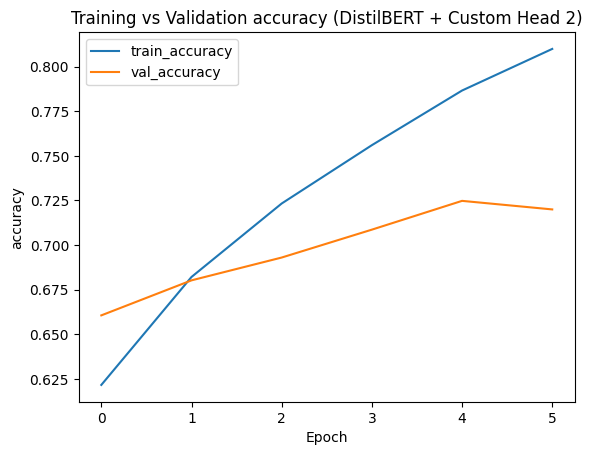

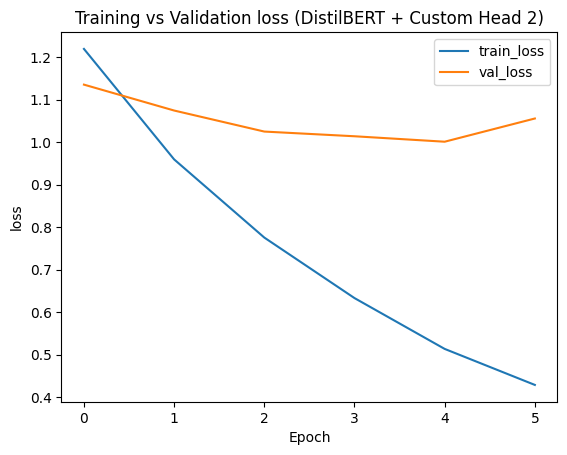

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report


def plot_history_bert(history, key="acc", title_suffix=""):
    train_key = next((k for k in history.history.keys() if k in (key, f"train_{key}", "acc", "accuracy")), None)
    val_key   = next((k for k in history.history.keys() if k in (f"val_{key}", "val_acc", "val_accuracy")), None)
    assert train_key and val_key, f"Keys not found in history: {list(history.history.keys())}"
    plt.figure()
    plt.plot(history.history[train_key], label=f"train_{key}")
    plt.plot(history.history[val_key],   label=f"val_{key}")
    plt.xlabel("Epoch"); plt.ylabel(key); plt.title(f"Training vs Validation {key} {title_suffix}".strip())
    plt.legend(); plt.show()


def plot_history_loss_bert(history, title_suffix=""):
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch"); plt.ylabel("loss"); plt.title(f"Training vs Validation loss {title_suffix}".strip())
    plt.legend(); plt.show()


plot_history_bert(history_ft, key="accuracy", title_suffix="(DistilBERT + Custom Head 2)")
plot_history_loss_bert(history_ft, title_suffix="(DistilBERT + Custom Head 2)")

In [38]:
model =  bertinator # model name for quick switching

EVAL_BATCH = 64

logits_or_probs = model.predict(
    {"text": X_test},
    batch_size=EVAL_BATCH,
    verbose=0
)

y_pred = np.argmax(logits_or_probs, axis=-1)

y_true = np.asarray(y_test)
test_acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"\n[Test] Accuracy: {test_acc:.4f} | Macro F1: {macro_f1:.4f}\n")
print(classification_report(
    y_true, y_pred,
    target_names=[id2cat[i] for i in range(NUM_CLASSES)],
    digits=3
))

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: text
Received: inputs=['Tensor(shape=(64,))']
  warnings.warn(msg)



[Test] Accuracy: 0.7123 | Macro F1: 0.6528

                        precision    recall  f1-score   support

  ARTS & ENTERTAINMENT      0.787     0.707     0.745      1993
      BUSINESS & MONEY      0.594     0.639     0.615       764
                COMEDY      0.473     0.576     0.519       516
                 CRIME      0.515     0.721     0.600       340
             EDUCATION      0.409     0.740     0.526       215
           ENVIRONMENT      0.520     0.680     0.590       394
FAMILY & RELATIONSHIPS      0.816     0.789     0.802      1962
          FOOD & DRINK      0.767     0.879     0.819       832
     HEALTH & WELLNESS      0.788     0.765     0.776      2591
         HOME & LIVING      0.839     0.812     0.825       416
                IMPACT      0.361     0.443     0.398       345
                 MEDIA      0.480     0.673     0.560       281
            OTHER NEWS      0.499     0.514     0.506       407
              POLITICS      0.915     0.633     0.748     

____

Experiment results: We started on training at 25% of the dataset to speed up testing any of the structural changes we had in mind.

# **Experiment 1: Deep Head Architecture**

In this one, we implemented a head with the following structure:

- 1028 Neurons (ReLu)

- Dropout 0.3

- 526 Neurons (ReLu)

- Dropout (0.3)

- 256 Neurons (ReLu)

And the results were:

 **Accuracy: 0.6884 | Macro F1: 0.6130**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.839     | 0.617  | 0.711    | 1993    |
| BLACK VOICES            | 0.479     | 0.633  | 0.545    | 452     |
| BUSINESS & MONEY        | 0.614     | 0.661  | 0.636    | 764     |
| COMEDY                  | 0.497     | 0.558  | 0.526    | 516     |
| CRIME                   | 0.550     | 0.709  | 0.620    | 340     |
| EDUCATION               | 0.449     | 0.716  | 0.552    | 215     |
| ENVIRONMENT             | 0.478     | 0.728  | 0.577    | 394     |
| FAMILY & RELATIONSHIPS  | 0.859     | 0.750  | 0.801    | 1962    |
| FIFTY                   | 0.203     | 0.657  | 0.310    | 140     |
| FOOD & DRINK            | 0.828     | 0.853  | 0.840    | 832     |
| GOOD NEWS               | 0.359     | 0.364  | 0.362    | 140     |
| HEALTH & WELLNESS       | 0.883     | 0.654  | 0.751    | 2451    |
| HOME & LIVING           | 0.714     | 0.858  | 0.779    | 416     |
| IMPACT                  | 0.333     | 0.520  | 0.406    | 346     |
| LATINO VOICES           | 0.359     | 0.779  | 0.492    | 113     |
| MEDIA                   | 0.452     | 0.683  | 0.544    | 281     |
| POLITICS                | 0.924     | 0.599  | 0.727    | 3272    |
| QUEER VOICES            | 0.743     | 0.751  | 0.747    | 631     |
| RELIGION                | 0.509     | 0.678  | 0.582    | 255     |
| SCIENCE                 | 0.514     | 0.674  | 0.583    | 218     |
| SPORTS                  | 0.735     | 0.781  | 0.757    | 489     |
| STYLE                   | 0.457     | 0.728  | 0.561    | 224     |
| STYLE & BEAUTY          | 0.875     | 0.855  | 0.865    | 951     |
| TECH                    | 0.386     | 0.631  | 0.479    | 203     |
| TRAVEL                  | 0.852     | 0.828  | 0.840    | 989     |
| WEIRD NEWS              | 0.504     | 0.434  | 0.467    | 267     |
| WOMEN                   | 0.277     | 0.618  | 0.383    | 340     |
| WORLD NEWS              | 0.657     | 0.800  | 0.722    | 842     |
              

              accuracy      0.688     20036
             macro avg      0.583     0.683     0.613     20036
          weighted avg      0.749     0.688     0.703     20036

# **Experiment 2: Classification head from round one ^  + two training rounds**

In this one, we split the training into two rounds, for round one (for a quick 3 epochs) we froze the bert backbone and *just* trained the classification head on the data. And then for round two, we unfroze the entire bert backbone and implemented 6 epochs with early stopping (patience of 2), to try to get rid of any vanishing gradients

**Accuracy: 0.6803 | Macro F1: 0.6063**

|Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.826     | 0.599  | 0.694    | 1993    |
| BLACK VOICES            | 0.518     | 0.575  | 0.545    | 452     |
| BUSINESS & MONEY        | 0.602     | 0.671  | 0.635    | 764     |
| COMEDY                  | 0.451     | 0.581  | 0.508    | 516     |
| CRIME                   | 0.532     | 0.709  | 0.608    | 340     |
| EDUCATION               | 0.452     | 0.698  | 0.548    | 215     |
| ENVIRONMENT             | 0.522     | 0.718  | 0.605    | 394     |
| FAMILY & RELATIONSHIPS  | 0.863     | 0.727  | 0.789    | 1962    |
| FIFTY                   | 0.147     | 0.664  | 0.241    | 140     |
| FOOD & DRINK            | 0.785     | 0.873  | 0.826    | 832     |
| GOOD NEWS               | 0.263     | 0.529  | 0.352    | 140     |
| HEALTH & WELLNESS       | 0.884     | 0.637  | 0.741    | 2451    |
| HOME & LIVING           | 0.626     | 0.861  | 0.725    | 416     |
| IMPACT                  | 0.389     | 0.379  | 0.384    | 346     |
| LATINO VOICES           | 0.378     | 0.752  | 0.503    | 113     |
| MEDIA                   | 0.410     | 0.719  | 0.522    | 281     |
| POLITICS                | 0.933     | 0.598  | 0.729    | 3272    |
| QUEER VOICES            | 0.749     | 0.753  | 0.751    | 631     |
| RELIGION                | 0.510     | 0.710  | 0.593    | 255     |
| SCIENCE                 | 0.472     | 0.734  | 0.575    | 218     |
| SPORTS                  | 0.729     | 0.775  | 0.751    | 489     |
| STYLE                   | 0.398     | 0.714  | 0.511    | 224     |
| STYLE & BEAUTY          | 0.848     | 0.838  | 0.843    | 951     |
| TECH                    | 0.480     | 0.640  | 0.549    | 203     |
| TRAVEL                  | 0.837     | 0.844  | 0.840    | 989     |
| WEIRD NEWS              | 0.435     | 0.536  | 0.480    | 267     |
| WOMEN                   | 0.308     | 0.544  | 0.394    | 340     |
| WORLD NEWS              | 0.722     | 0.752  | 0.736    | 842     |


              accuracy                          0.680     20036
             macro avg      0.574     0.683     0.606     20036
          weighted avg      0.746     0.680     0.696     20036


# **Experiment 3: Same classification head design from experiment 1 + 50 % of data (up from 25%) + reduce on plateau + more epochs (in combination with early stopping to prevent overfitting**

The idea here was to ratchet up the amount of data that we were training on because the model was still under performing on the under represented categories, and extend out the hard cap on the amount of training epochs because the model was using up all of them as we went. Figured that with LR Scheduling and early stopping, that would prevent us from overfitting and then extending out the epochs would make sure that we're not underfitting either.


- **Accuracy: 0.6848 | Macro F1: 0.6124**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.838     | 0.630  | 0.719    | 1993    |
| BLACK VOICES            | 0.479     | 0.648  | 0.551    | 452     |
| BUSINESS & MONEY        | 0.588     | 0.677  | 0.629    | 764     |
| COMEDY                  | 0.461     | 0.587  | 0.517    | 516     |
| CRIME                   | 0.536     | 0.738  | 0.621    | 340     |
| EDUCATION               | 0.405     | 0.730  | 0.521    | 215     |
| ENVIRONMENT             | 0.536     | 0.703  | 0.608    | 394     |
| FAMILY & RELATIONSHIPS  | 0.858     | 0.720  | 0.783    | 1962    |
| FIFTY                   | 0.165     | 0.671  | 0.265    | 140     |
| FOOD & DRINK            | 0.845     | 0.845  | 0.845    | 832     |
| GOOD NEWS               | 0.344     | 0.443  | 0.388    | 140     |
| HEALTH & WELLNESS       | 0.874     | 0.656  | 0.750    | 2451    |
| HOME & LIVING           | 0.747     | 0.822  | 0.783    | 416     |
| IMPACT                  | 0.401     | 0.431  | 0.415    | 346     |
| LATINO VOICES           | 0.340     | 0.770  | 0.472    | 113     |
| MEDIA                   | 0.435     | 0.712  | 0.540    | 281     |
| POLITICS                | 0.932     | 0.587  | 0.720    | 3272    |
| QUEER VOICES            | 0.729     | 0.764  | 0.746    | 631     |
| RELIGION                | 0.493     | 0.714  | 0.583    | 255     |
| SCIENCE                 | 0.455     | 0.739  | 0.563    | 218     |
| SPORTS                  | 0.703     | 0.824  | 0.759    | 489     |
| STYLE                   | 0.479     | 0.674  | 0.560    | 224     |
| STYLE & BEAUTY          | 0.857     | 0.840  | 0.849    | 951     |
| TECH                    | 0.444     | 0.685  | 0.539    | 203     |
| TRAVEL                  | 0.855     | 0.815  | 0.834    | 989     |
| WEIRD NEWS              | 0.500     | 0.472  | 0.486    | 267     |
| WOMEN                   | 0.282     | 0.576  | 0.378    | 340     |
| WORLD NEWS              | 0.688     | 0.765  | 0.724    | 842     |
                        

              accuracy      0.685     20036
             macro avg      0.581     0.687     0.612     20036
          weighted avg      0.749     0.685     0.701     20036

# **Experiment 4: Structural Changes from Experiment 3 + further label consolidation**




Because the architectural changes were not moving the needle much, we went through the class labels and did a second pass on investigating if any of them are semantically similar still.

Using the bar of our original Jaccard similarity analysis as a measuring stick: If the categories seemed like they covered the same material in general from looking at the descriptions and had a jaccard similarity score above the one encountered between Arts & culture and the Culture & arts, then that was deemed good enough to consolidate. These are the final category consolidations:


    "FIFTY": "HEALTH & WELLNESS",            # ADDED AFTER SECOND ROUND - This relates to living after 50

    # Regarding Voices and Identity
    "BLACK VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND -
    "LATINO VOICES": "VOICES & IDENTITY",         # ADDED AFTER SECOND ROUND
    "QUEER VOICES": "VOICES & IDENTITY",          # ADDED AFTER SECOND ROUND
    "WOMEN": "VOICES & IDENTITY",                                          # ADDED AFTER THIRD ROUND


    "GOOD NEWS": "OTHER NEWS",                  # ADDED AFTER SECOND ROUND - semantically more similar than Arts and Culture and Culture and Arts
    "WEIRD NEWS": "OTHER NEWS",                 # ADDED AFTER SECOND ROUND
}


- **Accuracy: 0.7003 | Macro F1: 0.6388**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.815     | 0.664  | 0.732    | 1993    |
| BUSINESS & MONEY        | 0.620     | 0.647  | 0.633    | 764     |
| COMEDY                  | 0.481     | 0.568  | 0.521    | 516     |
| CRIME                   | 0.468     | 0.797  | 0.590    | 340     |
| EDUCATION               | 0.413     | 0.726  | 0.526    | 215     |
| ENVIRONMENT             | 0.581     | 0.627  | 0.603    | 394     |
| FAMILY & RELATIONSHIPS  | 0.864     | 0.731  | 0.792    | 1962    |
| FOOD & DRINK            | 0.773     | 0.885  | 0.825    | 832     |
| HEALTH & WELLNESS       | 0.856     | 0.675  | 0.755    | 2591    |
| HOME & LIVING           | 0.759     | 0.853  | 0.803    | 416     |
| IMPACT                  | 0.312     | 0.507  | 0.387    | 345     |
| MEDIA                   | 0.456     | 0.698  | 0.551    | 281     |
| OTHER NEWS              | 0.473     | 0.565  | 0.515    | 407     |
| POLITICS                | 0.904     | 0.648  | 0.754    | 3272    |
| RELIGION                | 0.434     | 0.827  | 0.570    | 255     |
| SCIENCE                 | 0.424     | 0.729  | 0.536    | 218     |
| SPORTS                  | 0.686     | 0.865  | 0.765    | 489     |
| STYLE                   | 0.450     | 0.627  | 0.524    | 225     |
| STYLE & BEAUTY          | 0.875     | 0.844  | 0.859    | 951     |
| TECH                    | 0.397     | 0.709  | 0.509    | 203     |
| TRAVEL                  | 0.824     | 0.839  | 0.832    | 989     |
| VOICES & IDENTITY       | 0.751     | 0.552  | 0.636    | 1196    |
| WOMEN                   | 0.307     | 0.582  | 0.402    | 340     |
| WORLD NEWS              | 0.633     | 0.810  | 0.711    | 842     |


# **Experiment 5: All changes above + consolidating women into voices and identity**

We were initially hesitant to do this as Women didn't seem like it fit the same pattern as 'black voices', 'latino voices', etc. It had some jaccard similarity with queer voices, but was not very similar to latino voices.

After looking at their website, the Women category was under the 'Voices' section with the others, so we figured we'd try it here:

- **Accuracy: 0.7154 | Macro F1: 0.6553**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.788     | 0.688  | 0.735    | 1993    |
| BUSINESS & MONEY        | 0.599     | 0.687  | 0.640    | 764     |
| COMEDY                  | 0.458     | 0.630  | 0.531    | 516     |
| CRIME                   | 0.482     | 0.738  | 0.583    | 340     |
| EDUCATION               | 0.431     | 0.735  | 0.543    | 215     |
| ENVIRONMENT             | 0.544     | 0.693  | 0.609    | 394     |
| FAMILY & RELATIONSHIPS  | 0.838     | 0.766  | 0.800    | 1962    |
| FOOD & DRINK            | 0.785     | 0.867  | 0.824    | 832     |
| HEALTH & WELLNESS       | 0.821     | 0.740  | 0.778    | 2591    |
| HOME & LIVING           | 0.739     | 0.851  | 0.791    | 416     |
| IMPACT                  | 0.341     | 0.455  | 0.390    | 345     |
| MEDIA                   | 0.432     | 0.698  | 0.533    | 281     |
| OTHER NEWS              | 0.504     | 0.486  | 0.495    | 407     |
| POLITICS                | 0.899     | 0.671  | 0.769    | 3272    |
| RELIGION                | 0.512     | 0.776  | 0.617    | 255     |
| SCIENCE                 | 0.487     | 0.683  | 0.569    | 218     |
| SPORTS                  | 0.708     | 0.873  | 0.782    | 489     |
| STYLE                   | 0.474     | 0.689  | 0.562    | 225     |
| STYLE & BEAUTY          | 0.830     | 0.860  | 0.845    | 951     |
| TECH                    | 0.387     | 0.670  | 0.491    | 203     |
| TRAVEL                  | 0.854     | 0.832  | 0.843    | 989     |
| VOICES & IDENTITY       | 0.698     | 0.553  | 0.617    | 1536    |
| WORLD NEWS              | 0.703     | 0.753  | 0.727    | 842     |
                      
              accuracy                          0.715     20036
             macro avg      0.622     0.713     0.655     20036
          weighted avg      0.744     0.715     0.722     20036


# **Experiment 6: Full Dataset**


- **Accuracy: 0.7123 | Macro F1: 0.6528**

| Category                | Precision | Recall | F1-Score | Support |
|-------------------------|-----------|--------|----------|---------|
| ARTS & ENTERTAINMENT    | 0.787     | 0.707  | 0.745    | 1993    |
| BUSINESS & MONEY        | 0.594     | 0.639  | 0.615    | 764     |
| COMEDY                  | 0.473     | 0.576  | 0.519    | 516     |
| CRIME                   | 0.515     | 0.721  | 0.600    | 340     |
| EDUCATION               | 0.409     | 0.740  | 0.526    | 215     |
| ENVIRONMENT             | 0.520     | 0.680  | 0.590    | 394     |
| FAMILY & RELATIONSHIPS  | 0.816     | 0.789  | 0.802    | 1962    |
| FOOD & DRINK            | 0.767     | 0.879  | 0.819    | 832     |
| HEALTH & WELLNESS       | 0.788     | 0.765  | 0.776    | 2591    |
| HOME & LIVING           | 0.839     | 0.812  | 0.825    | 416     |
| IMPACT                  | 0.361     | 0.443  | 0.398    | 345     |
| MEDIA                   | 0.480     | 0.673  | 0.560    | 281     |
| OTHER NEWS              | 0.499     | 0.514  | 0.506    | 407     |
| POLITICS                | 0.915     | 0.633  | 0.748    | 3272    |
| RELIGION                | 0.478     | 0.796  | 0.597    | 255     |
| SCIENCE                 | 0.518     | 0.656  | 0.579    | 218     |
| SPORTS                  | 0.669     | 0.863  | 0.754    | 489     |
| STYLE                   | 0.435     | 0.689  | 0.534    | 225     |
| STYLE & BEAUTY          | 0.862     | 0.829  | 0.845    | 951     |
| TECH                    | 0.386     | 0.690  | 0.495    | 203     |
| TRAVEL                  | 0.827     | 0.841  | 0.834    | 989     |
| VOICES & IDENTITY       | 0.674     | 0.576  | 0.621    | 1536    |
| WORLD NEWS              | 0.715     | 0.734  | 0.725    | 842     |

____

#### **Notes so far:**

Combining the Style and Style & Beauty sections resulted in a drop in performance so that was unwound.

The worst performer was IMPACT. - So far I'm not sure how to ameliorate that. It's similar enough to everything else that it's not distinct but not so similar that it can be combined with anything. Even when I scoured their website